In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

# What that's look like ?

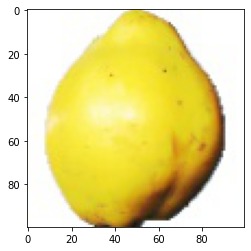

In [3]:
image = imread("/kaggle/input/fruits/fruits-360/Training/Quince/184_100.jpg")
plt.imshow(image)

In [4]:
image.shape

(100, 100, 3)

In [5]:
IMSIZE = [100, 100]

# Create dataset + data augmentation

In [6]:
src_path_train = "../input/fruits/fruits-360/Training"
src_path_test = "../input/fruits/fruits-360/Test"

image_gen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

batch_size = 32

# create generators
train_generator = image_gen.flow_from_directory(
  src_path_train,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

test_generator = image_gen.flow_from_directory(
  src_path_test,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


There are 131 classes

In [7]:
from glob import glob
train_image_files = glob(src_path_train + '/*/*.jp*g')
test_image_files = glob(src_path_test + '/*/*.jp*g')
len(image_files), len(valid_image_files)

NameError: name 'image_files' is not defined

In [8]:
NBCLASSES = 131

# Model creation / from VGG16

In [9]:
def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
    
    # get the VGG output
    out = vgg.output
    
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
    
    model = Model(inputs=vgg.input, outputs=x)
    
    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

mymodel = create_model()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

# Fit the model now

In [10]:
epochs = 10
early_stop = EarlyStopping(monitor='val_loss',patience=2)
r = mymodel.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  steps_per_epoch=len(train_image_files) // batch_size,
  validation_steps=len(test_image_files) // batch_size,
  callbacks=[early_stop]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2115/2115 [==============================] - 647s 304ms/step - loss: 0.0269 - accuracy: 0.6334 - val_loss: 0.0085 - val_accuracy: 0.8802
Epoch 2/10
2115/2115 [==============================] - 289s 136ms/step - loss: 0.0037 - accuracy: 0.9787 - val_loss: 0.0055 - val_accuracy: 0.9295
Epoch 3/10
2115/2115 [==============================] - 290s 137ms/step - loss: 0.0018 - accuracy: 0.9923 - val_loss: 0.0047 - val_accuracy: 0.9391
Epoch 4/10
2115/2115 [==============================] - 296s 140ms/step - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0043 - val_accuracy: 0.9522
Epoch 5/10
2115/2115 [==============================] - 298s 141ms/step - loss: 8.8540e-04 - accuracy: 0.9967 - val_loss: 0.0040 - val_accuracy: 0.9524
Epoch 6/10
2115/2115 [==============================] - 298s 141ms/step - loss: 6.6982e-04 - accuracy: 0.9985 - val_loss: 0.0037 - val_accuracy: 0.9600
Epoch 7/10
2115/2115 [==============================] - 299s 142ms/step - loss: 5.5506e-04 - accuracy: 0

In [11]:
score = mymodel.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.003505550790578127
Test accuracy: 0.9680007100105286


**Accuracy 97%**